In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt
import keras

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetections2 import DecodeDetections2
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

C:\Users\Aditya\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
# Set the image size.
img_height = 300
img_width = 300

In [12]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=80,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'VGG_coco_SSD_300x300_iter_400000.h5'
print(model)

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [63]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = 'imgs/scene.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

In [64]:
y_pred = model.predict(input_images)

In [65]:
print(y_pred.shape)

(1, 200, 6)


In [66]:
confidence_threshold = 0.3

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 60.     0.97  93.61 150.81 254.19 266.73]
 [ 59.     0.81  77.85 125.9  116.97 168.07]
 [ 57.     0.65 230.51 179.01 298.88 295.37]]


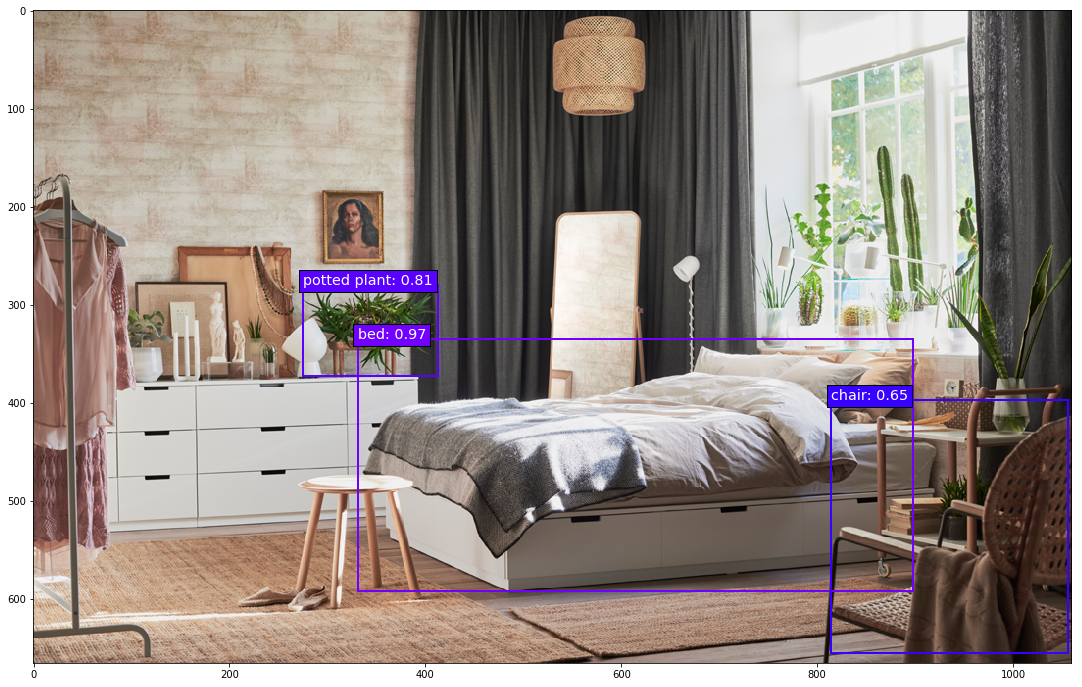

In [67]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 81)).tolist()
classes = ["background","person","bicycle","car","motorcycle","airplane","bus","train","truck","boat","traffic light","fire hydrant","stop sign","parking meter","bench","bird","cat","dog","horse","sheep","cow","elephant","bear","zebra","giraffe","backpack","umbrella","handbag","tie","suitcase","frisbee","skis","snowboard","sports ball","kite","baseball bat","baseball glove","skateboard","surfboard","tennis racket","bottle","wine glass","cup","fork","knife","spoon","bowl","banana","apple","sandwich","orange","broccoli","carrot","hot dog","pizza","donut","cake","chair","couch","potted plant","bed","dining table","toilet","tv","laptop","mouse","remote","keyboard","cell phone","microwave","oven","toaster","sink","refrigerator","book","clock","vase","scissors","teddy bear","hair drier","toothbrush"]

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_thresh[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})